프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
(어떠한 방법을 사용했는지 적어주세요.)
1. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
1. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
1. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
1. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [14]:
!unzip *.zip

Archive:  cityscapes.zip
   creating: cityscapes/
   creating: cityscapes/train/
  inflating: cityscapes/train/1.jpg  
  inflating: cityscapes/train/100.jpg  
  inflating: cityscapes/train/1000.jpg  
  inflating: cityscapes/train/101.jpg  
  inflating: cityscapes/train/102.jpg  
  inflating: cityscapes/train/106.jpg  
  inflating: cityscapes/train/109.jpg  
  inflating: cityscapes/train/112.jpg  
  inflating: cityscapes/train/113.jpg  
  inflating: cityscapes/train/114.jpg  
  inflating: cityscapes/train/116.jpg  
  inflating: cityscapes/train/119.jpg  
  inflating: cityscapes/train/12.jpg  
  inflating: cityscapes/train/124.jpg  
  inflating: cityscapes/train/128.jpg  
  inflating: cityscapes/train/135.jpg  
  inflating: cityscapes/train/137.jpg  
  inflating: cityscapes/train/139.jpg  
  inflating: cityscapes/train/140.jpg  
  inflating: cityscapes/train/144.jpg  
  inflating: cityscapes/train/148.jpg  
  inflating: cityscapes/train/153.jpg  
  inflating: cityscapes/train/154.jpg  
 

In [77]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
import matplotlib.pyplot as plt

import os

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

데이터 준비하기

In [79]:
!pwd

/aiffel/aiffel/conditional_generation


In [80]:
data_path = '/aiffel/aiffel/conditional_generation/cityscapes/train/'

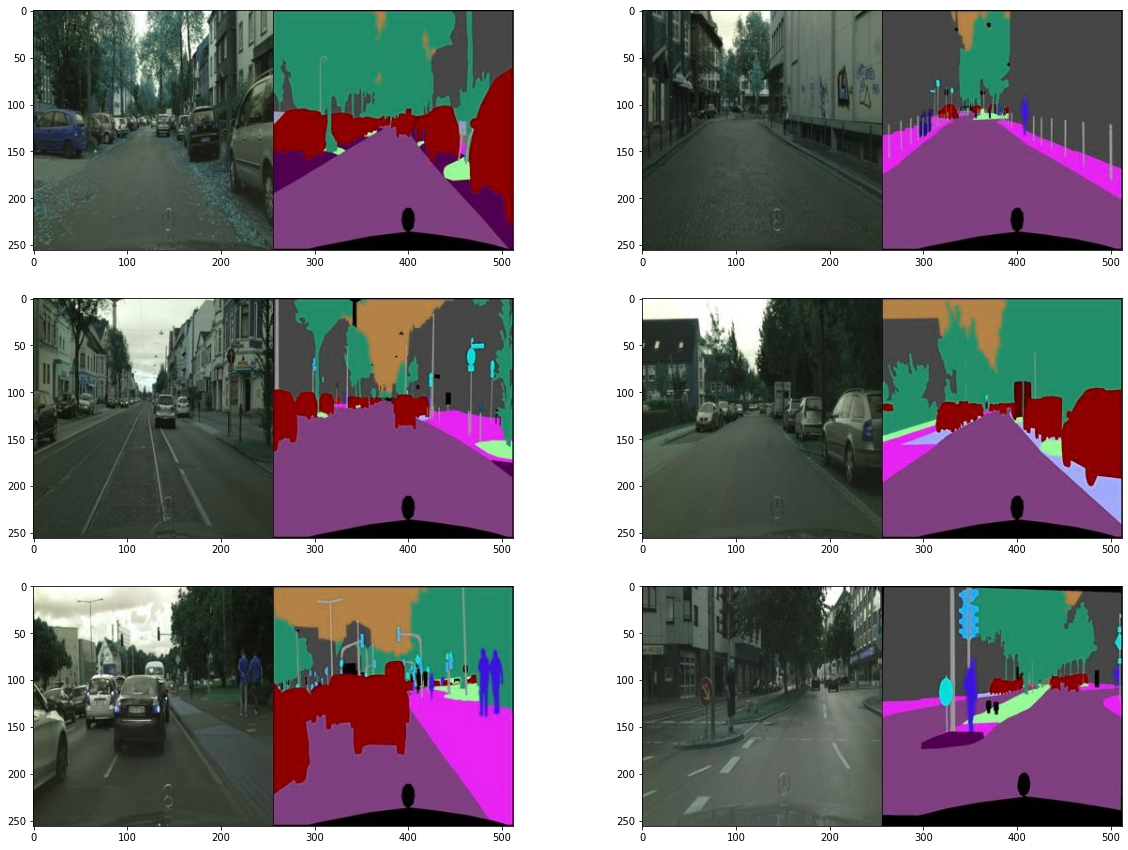

In [53]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(len(os.listdir(data_path)))]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [54]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


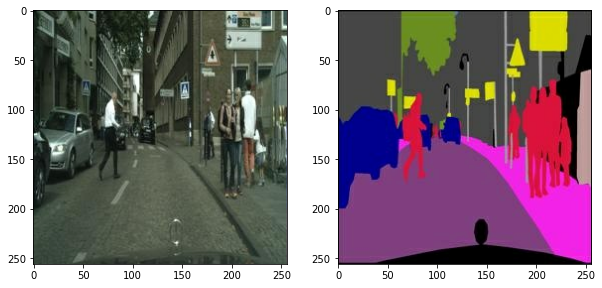

In [81]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [82]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


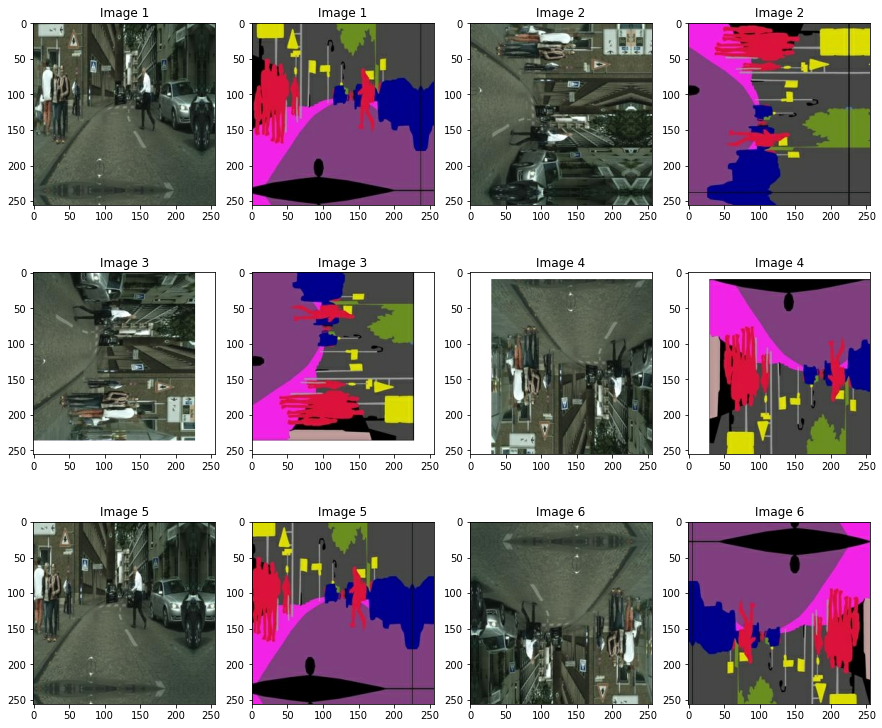

In [83]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

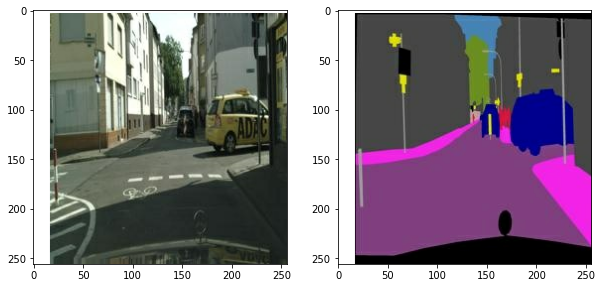

In [84]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

data_path = '/aiffel/aiffel/conditional_generation/cityscapes/val/'

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [85]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [86]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [87]:
UNetGenerator().get_summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_32 (EncodeBlock)   (None, 128, 128, 64) 3072        input_9[0][0]                    
__________________________________________________________________________________________________
encode_block_33 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_32[0][0]            
__________________________________________________________________________________________________
encode_block_34 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_33[0][0]            
____________________________________________________________________________________________

In [88]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [89]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_98 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_70 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [90]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [91]:
Discriminator().get_summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_49 (Concatenate)    (None, 256, 256, 6)  0           input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
disc_block_35 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_49[0][0]       

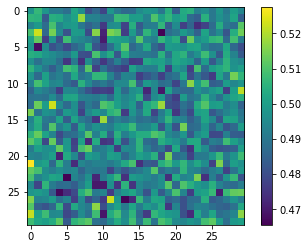

In [92]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [93]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [94]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [110]:
@tf.function
def train_step(semap, real_road):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_road = generator(semap, training=True)
        # Discriminator 예측
        fake_disc = discriminator(semap, fake_road, training=True)
        real_disc = discriminator(semap, real_road, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_road, real_road, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [111]:
EPOCHS = 100 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

history = {'gen_loss':[],'l1_loss':[],'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (segmap, road) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmap, road)
        
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
        
        print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                \nGenerator_loss:{g_loss.numpy():.4f} \
                \nL1_loss:{l1_loss.numpy():.4f} \
                \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[1]                 
Generator_loss:0.4533                 
L1_loss:0.5937                 
Discriminator_loss:1.6785

EPOCH[1] - STEP[2]                 
Generator_loss:5.0420                 
L1_loss:0.4717                 
Discriminator_loss:6.6421

EPOCH[2] - STEP[1]                 
Generator_loss:5.1645                 
L1_loss:0.4225                 
Discriminator_loss:6.4031

EPOCH[2] - STEP[2]                 
Generator_loss:3.1548                 
L1_loss:0.3714                 
Discriminator_loss:3.3147

EPOCH[3] - STEP[1]                 
Generator_loss:0.7989                 
L1_loss:0.3580                 
Discriminator_loss:2.2317

EPOCH[3] - STEP[2]                 
Generator_loss:0.8271                 
L1_loss:0.3630                 
Discriminator_loss:2.4127

EPOCH[4] - STEP[1]                 
Generator_loss:0.3119                 
L1_loss:0.3208                 
Discriminator_loss:2.0632

EPOCH[4] - STEP[2]                 
Generator_loss:0.4822     

In [97]:
os.listdir(data_path)

['1.jpg', '5.jpg', '2.jpg', '3.jpg', '4.jpg']

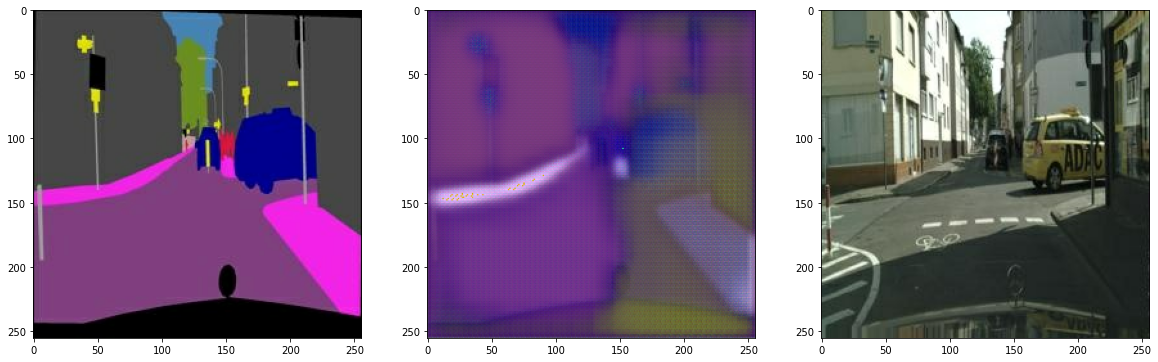

In [112]:
test_ind = 0

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(colored, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))

plt.subplot(1,3,1); plt.imshow(denormalize(colored))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(sketch))

# 회고
- cGAN에 대해 학습하였다
- GAN은 Discriminator를 학습하고, Generator를 학습하는 식으로 학습이 이루어진다.
- 결과적으로 Discriminator는 Generator가 생성한 이미지를 구분하지 못할 때 학습이 완료되었다고 볼 수 있다.